In [0]:
# speed up the loading of the training data
import cv2
import os
import numpy as np
import torch as th
import itertools
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torchvision.utils import make_grid

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

model_module = drive.CreateFile({'id':'18Z0qjtpejXQ1txMaDXjSKNSI0h6Q6drj'})
dataset_module = drive.CreateFile({'id':'1VXZzhRO0b1GsqefbuZ7rpouF8gb9eZEC'})
model_module.GetContentFile('model.py')
dataset_module.GetContentFile('data_set.py')
from model import NetG, NetD, NetA
from data_set import LookbookDataset

In [0]:
#tbc=TensorBoardColab()
#vis = visdom.Visdom(port=5274)
#writer = SummaryWriter()
win = None
win1 = None
netg = NetG()
netd = NetD()
neta = NetA()
netg.train()
netd.train()
neta.train()
device = th.device("cuda")

In [0]:
# weights init
all_mods = itertools.chain()
all_mods = itertools.chain(all_mods, [
    list(netg.children())[0].children(),
    list(netd.children())[0].children(),
    list(neta.children())[0].children()
])

In [0]:
for mod in all_mods:
    if isinstance(mod, nn.Conv2d) or isinstance(mod, nn.ConvTranspose2d):
        init.normal_(mod.weight, 0.0, 0.02)
    elif isinstance(mod, nn.BatchNorm2d):
        init.normal_(mod.weight, 1.0, 0.02)
        init.constant_(mod.bias, 0.0)

In [0]:
netg = netg.to(device)
netd = netd.to(device)
neta = neta.to(device)

In [0]:
dataset = LookbookDataset(data_dir='/content/drive/My Drive/Colab Notebooks/ViewU/',
                          index_dir='/content/drive/My Drive/Colab Notebooks/')

iteration = 0
lr = 0.0002
real_label = 1
fake_label = 0
fineSize = 64

In [0]:
label = th.zeros((128, 1), requires_grad=False).to(device)
optimG = optim.Adam(netg.parameters(), lr=lr/2)
optimD = optim.Adam(netd.parameters(), lr=lr/3)
optimA = optim.Adam(neta.parameters(), lr=lr/3)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
#def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    #npimg = img.numpy()
    #plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(np.transpose(img, (1, 2, 0)))
    #plt.imshow(np.reshape(img, (28, 28)))
    #plt.imshow(img.permute(1, 2, 0))
    #plt.imshow((img * 255).astype(np.uint8))
    #img = img.numpy().transpose((1, 2, 0))
    #plt.imshow(np.transpose(img, (1,2,0)), interpolation='nearest')
    #plt.imshow(img)

Training starts
iter = 20, ErrG = 4.137544095516205, ErrA = 1.0429142713546753, ErrD = 0.6652942498524984


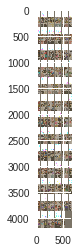

KeyboardInterrupt: ignored

In [11]:
print('Training starts')
while iteration < 1000000:
    ass_label, noass_label, img1, img2 = dataset.getbatch(128)
    ass_label = ass_label.to(device).to(th.float32)
    noass_label = noass_label.to(device).to(th.float32)
    img1 = img1.to(device).to(th.float32)
    img2 = img2.to(device).to(th.float32)
    # update D
    lossD = 0
    optimD.zero_grad()
    output = netd(ass_label)
    label.fill_(real_label)
    lossD_real1 = F.binary_cross_entropy(output, label)
    lossD += lossD_real1.item()
    lossD_real1.backward()

    label.fill_(real_label)
    output1 = netd(noass_label)
    lossD_real2 = F.binary_cross_entropy(output1, label)
    lossD == lossD_real2.item()
    lossD_real2.backward()

    fake = netg(img1).detach()
    label.fill_(fake_label)
    output2 = netd(fake)

    lossD_fake1 = F.binary_cross_entropy(output2, label)
    lossD += lossD_fake1.item()
    lossD_fake1.backward()

    fake = netg(img2).detach()
    label.fill_(fake_label)
    output3 = netd(fake)

    lossD_fake2 = F.binary_cross_entropy(output3, label)
    lossD += lossD_fake2.item()
    lossD_fake2.backward()

    optimD.step()
    # update A
    lossA = 0
    optimA.zero_grad()
    assd1 = th.cat((img1, ass_label), 1)
    assd2 = th.cat((img2, ass_label), 1)
    noassd1 = th.cat((img1, noass_label), 1)
    noassd2 = th.cat((img2, noass_label), 1)
    fake1 = netg(img1).detach()
    fake2 = netg(img2).detach()
    faked1 = th.cat((img1, fake1), 1)
    faked2 = th.cat((img2, fake2), 1)

    label.fill_(real_label)
    output1 = neta(assd1)
    lossA_real1 = F.binary_cross_entropy(output1, label)
    lossA += lossA_real1.item()
    lossA_real1.backward()

    label.fill_(real_label)
    output2 = neta(assd2)
    lossA_real2 = F.binary_cross_entropy(output2, label)
    lossA += lossA_real2.item()
    lossA_real2.backward()

    label.fill_(fake_label)
    output3 = neta(noassd1)
    lossA_real3 = F.binary_cross_entropy(output3, label)
    lossA += lossA_real3.item()
    lossA_real3.backward()

    label.fill_(fake_label)
    output4 = neta(noassd2)
    lossA_real4 = F.binary_cross_entropy(output4, label)
    lossA += lossA_real4.item()
    lossA_real4.backward()

    label.fill_(fake_label)
    output5 = neta(faked1)
    lossA_fake1 = F.binary_cross_entropy(output5, label)
    lossA += lossA_fake1.item()
    lossA_fake1.backward()

    label.fill_(fake_label)
    output6 = neta(faked2)
    lossA_fake2 = F.binary_cross_entropy(output6, label)
    lossA += lossA_fake2.item()
    lossA_fake2.backward()
    optimA.step()
    # update G
    lossG = 0
    optimG.zero_grad()
    fake1 = netg(img1)
    output1 = netd(fake1)

    label.fill_(real_label)
    lossGD = F.binary_cross_entropy(output1, label)
    lossG += lossGD.item()
    lossGD.backward(retain_graph=True)

    fake2 = netg(img2)
    output2 = netd(fake2)

    label.fill_(real_label)
    lossGD = F.binary_cross_entropy(output2, label)
    lossG += lossGD.item()
    lossGD.backward(retain_graph=True)

    faked1 = th.cat((img1, fake1), 1)
    output3 = neta(faked1)
    label.fill_(real_label)
    lossGA = F.binary_cross_entropy(output3, label)
    lossG += lossGA.item()
    lossGA.backward()

    faked2 = th.cat((img2, fake2), 1)
    output4 = neta(faked2)
    label.fill_(real_label)
    lossGA = F.binary_cross_entropy(output4, label)
    lossG += lossGA.item()
    lossGA.backward()
    optimG.step()

    iteration += 1

    if iteration % 20 == 0:
      with th.no_grad():
        netg.eval()
        fake1 = netg(img1)
        fake2 = netg(img2)
        netg.train()
      fake1 = (fake1 + 1) / 2 * 255
      fake2 = (fake2 + 1) / 2 * 255
      real = (ass_label + 1) / 2 * 255
      ori1 = (img1 + 1) / 2 * 255
      ori2 = (img2 + 1) / 2 * 255
      #al = th.cat((fake1, fake2, real, ori1, ori2), 2)
      al = th.cat((fake1, fake2, ass_label, img1, img2), 2)
      display = make_grid(al, 10).cpu()#.numpy()
      print('iter = {}, ErrG = {}, ErrA = {}, ErrD = {}'.format(iteration, lossG/2, lossA/3, lossD/3))
      imshow(display)
    if(iteration%100==0):
      os.mkdir('/content/drive/My Drive/Colab Notebooks/ViewU-code/checkpoints/checkpoints_'+str(iteration))
      th.save(netg.state_dict(),'/content/drive/My Drive/Colab Notebooks/ViewU-code/checkpoints/checkpoints_'+str(iteration)+'/netG_iter_'+str(iteration)+'.t7')
      th.save(netd.state_dict(),'/content/drive/My Drive/Colab Notebooks/ViewU-code/checkpoints/checkpoints_'+str(iteration)+'/netD_iter_'+str(iteration)+'.t7')
      th.save(neta.state_dict(),'/content/drive/My Drive/Colab Notebooks/ViewU-code/checkpoints/checkpoints_'+str(iteration)+'/netA_iter_'+str(iteration)+'.t7')
